In [1]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 26.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 98.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━

In [2]:
# Standard libraries
import os
import warnings
import math
import random
from pathlib import Path
from collections import Counter, OrderedDict
from typing import List, Tuple, Dict, Optional, Union, Callable
from enum import IntEnum

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from tqdm import tqdm
from ipywidgets import interact

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset

# Torchvision
import torchvision.transforms as transforms

# Flower
import flwr
from flwr.client import Client, ClientApp
from flwr.common import (
    Code, EvaluateIns, EvaluateRes, FitIns, FitRes, GetParametersIns, GetParametersRes,
    Status, Parameters, Scalar, NDArray, NDArrays, ndarrays_to_parameters, parameters_to_ndarrays, Context
)
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import Strategy
from flwr.simulation import run_simulation

# HuggingFace Datasets
from datasets.utils.logging import disable_progress_bar, set_verbosity_error

2025-05-23 11:17:11.735444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747999031.922637      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747999031.977415      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Thiết lập thiết bị
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()
set_verbosity_error()
warnings.filterwarnings("ignore")

# Định nghĩa drop out
class CustomCode(IntEnum):
    DROPPED_OUT = 100

Training on cuda
Flower 1.18.0 / PyTorch 2.6.0+cu124


In [4]:
# config
NUM_CLIENTS = 10
NUM_ROUNDS = 10
DROPOUT = 0.3
BATCHSIZE = 14
LR = 0.001
epochs_round = 1

In [5]:
data_dir = '/kaggle/input/mri-dataset/datasetzip/not_skull_stripped'
label_path = list(Path(data_dir).glob("*.xlsx"))
label_ls = pd.read_excel(label_path[0])
label_ls

,subject_age,subject_dx,subject_sex,subject_id,dataset_name
0,55.4,pathology,m,sub-BrainAge000000,ABIDE/Caltech
1,22.9,pathology,m,sub-BrainAge000001,ABIDE/Caltech
2,39.2,pathology,m,sub-BrainAge000002,ABIDE/Caltech
3,22.8,pathology,m,sub-BrainAge000003,ABIDE/Caltech
4,34.6,pathology,f,sub-BrainAge000004,ABIDE/Caltech
...,...,...,...,...,...
23209,66,control,f,sub-BrainAge023209,RocklandSample
23210,69,control,m,sub-BrainAge023210,RocklandSample
23211,23,control,m,sub-BrainAge023211,RocklandSample
23212,54,control,f,sub-BrainAge023212,RocklandSample


In [6]:
label_ls = label_ls[(label_ls['subject_dx'] == 'control') & ((label_ls['subject_sex'] == 'm') | (label_ls['subject_sex'] == 'f'))]
len(label_ls)

8764

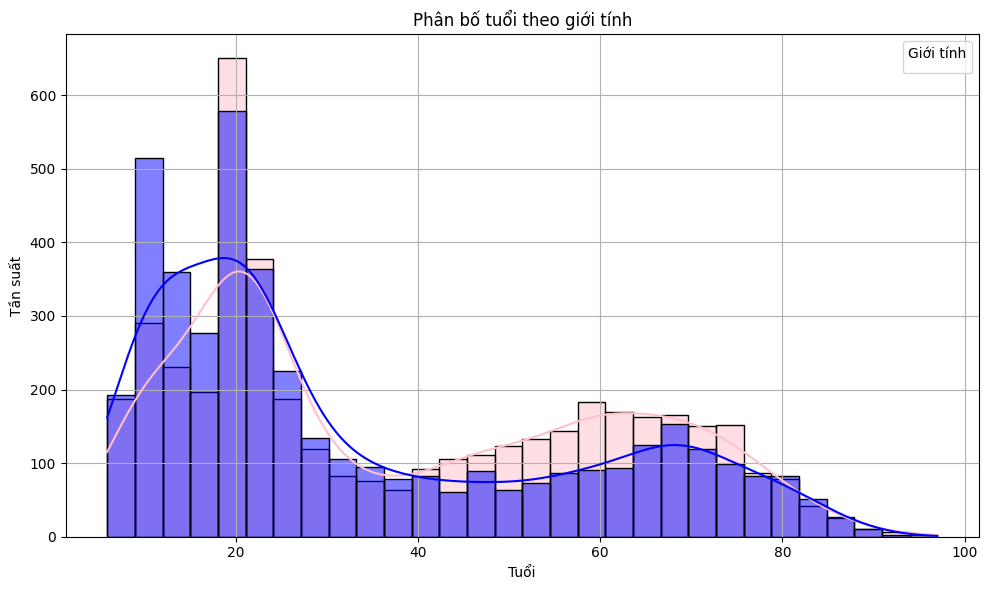

In [7]:
label_ls['subject_age'] = pd.to_numeric(label_ls['subject_age'], errors='coerce')
label_ls = label_ls.dropna(subset=['subject_age'])

plt.figure(figsize=(10, 6))

sns.histplot(data=label_ls, x="subject_age", hue="subject_sex", bins=30, kde=True, 
             palette={"m": "blue", "f": "pink"}, edgecolor="black", discrete=False)

plt.title('Phân bố tuổi theo giới tính')
plt.xlabel('Tuổi')
plt.ylabel('Tần suất')
plt.legend(title='Giới tính')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
subject_metadata = label_ls[['subject_sex','subject_id','dataset_name','subject_age']]
subject_metadata

,subject_sex,subject_id,dataset_name,subject_age
19,m,sub-BrainAge000019,ABIDE/Caltech,44.2
20,m,sub-BrainAge000020,ABIDE/Caltech,39.3
21,m,sub-BrainAge000021,ABIDE/Caltech,42.5
22,m,sub-BrainAge000022,ABIDE/Caltech,19.7
23,f,sub-BrainAge000023,ABIDE/Caltech,20.0
...,...,...,...,...
23209,f,sub-BrainAge023209,RocklandSample,66.0
23210,m,sub-BrainAge023210,RocklandSample,69.0
23211,m,sub-BrainAge023211,RocklandSample,23.0
23212,f,sub-BrainAge023212,RocklandSample,54.0


In [9]:
subject_metadata_dict = label_ls.set_index('subject_id')[['subject_sex','dataset_name','subject_age']].to_dict(orient='index')
len(subject_metadata_dict)

8717

In [10]:
class MRIDataset(Dataset):
    def __init__(self, im_dir, label_ls, transform=None, im_filenames=None):
        self.im_dir = Path(im_dir)
        self.label_ls = label_ls
        self.transform = transform

        if im_filenames is not None:
            self.im_filenames = im_filenames
        else:
            self.im_filenames = self._gather_valid_paths()

    def _gather_valid_paths(self):
        paths = self.im_dir.glob("*/*/*/*.nii")
        valid_paths = []
        fail_paths = {
            self.im_dir / "sub-BrainAge005600/anat/sub-BrainAge005600_T1w.nii/sub-BrainAge005600_T1w.nii"
        }

        for path in paths:
            if not path.is_file():
                continue
                
            if path in fail_paths:
                continue
                
            subject_id = self._extract_subject_id(path)
            if subject_id not in self.label_ls:
                continue
            try:
                # nib.load(path).get_fdata()
                nib.load(path)
                valid_paths.append(path)
            except Exception:
                continue
        return valid_paths

    def _extract_subject_id(self, path):
        for part in Path(path).parts:
            if part.startswith("sub-BrainAge"):
                return part  # ví dụ: "sub-BrainAge000000"
        return None

    def _normalize(self, im):
        im = (im - np.min(im)) / (np.max(im) - np.min(im) + 1e-5)
        return im.astype(np.float32)

    def _get_label(self, subject_id):
        sex = self.label_ls.get(subject_id, {}).get("subject_sex")
        if sex == 'm':
            return 0
        elif sex == 'f':
            return 1
        else:
            raise ValueError(f"Invalid label for subject {subject_id}: {sex}")
            
    def _get_age(self, subject_id):
        return self.label_ls.get(subject_id, {}).get("subject_age")
    
    def __len__(self):
        return len(self.im_filenames)

    def __getitem__(self, idx):
        im_path = self.im_filenames[idx]
        subject_id = self._extract_subject_id(im_path)

        im = nib.load(im_path).get_fdata()
        im = self._normalize(im)

        label = self._get_label(subject_id)
        image = torch.from_numpy(im).unsqueeze(0)  # Shape: (1, H, W, D)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)
        
    def num_classes(self):
        class_set = set()
        for idx in range(len(self)):
            _, label = self[idx]
            class_set.add(label.item())
        return len(class_set)    

In [11]:
def create_global_bin_pool(data: MRIDataset) -> dict:
    subject_metadata = data.label_ls
    subject_ids = [data._extract_subject_id(path) for path in data.im_filenames]

    age_array = np.array([
        subject_metadata.get(sid, {}).get("subject_age", np.nan)
        for sid in subject_ids
    ], dtype=np.float32)

    valid_mask = ~np.isnan(age_array)
    valid_indices = np.arange(len(data.im_filenames))[valid_mask]
    age_array = age_array[valid_mask]

    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    age_bins = np.digitize(age_array, bins, right=False)

    global_bin_pool = {}
    for bin_id in np.unique(age_bins):
        bin_indices = valid_indices[age_bins == bin_id]
        global_bin_pool[bin_id] = set(bin_indices.tolist())

    return global_bin_pool


def get_sample_data(
    data: MRIDataset,
    overlap: float,
    partition_id: int,
    num_partitions: int,
    global_bin_pool: dict,
    num_samples: int = None,
) -> list:
    subject_metadata = data.label_ls
    subject_ids = [data._extract_subject_id(path) for path in data.im_filenames]

    age_array = np.array(
        [subject_metadata.get(sid, {}).get("subject_age", np.nan) for sid in subject_ids],
        dtype=np.float32
    )

    valid_mask = ~np.isnan(age_array)
    valid_indices = np.arange(len(data.im_filenames))[valid_mask]
    age_array = age_array[valid_mask]

    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    age_bins = np.digitize(age_array, bins, right=False)
    total_samples = len(valid_indices)
    client_sample_count = total_samples // num_partitions

    rng = np.random.default_rng(seed=partition_id + 42)
    sampled_indices = set()
    used_bins = set()

    all_bins = list(global_bin_pool.keys())
    rng.shuffle(all_bins)
    target_num_bins = max(1, int(overlap * len(all_bins)))

    # Vòng lặp đến khi đủ sample
    while len(sampled_indices) < client_sample_count:
        # Chọn bin chưa dùng
        candidate_bins = [b for b in all_bins if b not in used_bins]
        if not candidate_bins:
            break  # Không còn bin nào để lấy

        selected_bins = candidate_bins[:target_num_bins]
        used_bins.update(selected_bins)

        # Lấy toàn bộ samples từ các bin đã chọn
        combined_indices = []
        for bin_id in selected_bins:
            available = global_bin_pool[bin_id]
            combined_indices.extend(list(available))

        rng.shuffle(combined_indices)

        # Chọn mẫu đến khi đủ
        needed = client_sample_count - len(sampled_indices)
        to_take = combined_indices[:needed]
        sampled_indices.update(to_take)

        # Xoá mẫu đã chọn khỏi global_bin_pool
        for idx in to_take:
            for bin_id in selected_bins:
                global_bin_pool[bin_id].discard(idx)

    if num_samples and num_samples > client_sample_count:
        remaining_needed = num_samples - client_sample_count
        remaining_pool = list(set(valid_indices) - sampled_indices)
        rng.shuffle(remaining_pool)
        extra = remaining_pool[:remaining_needed]
        sampled_indices.update(extra)

    return list(sampled_indices)

In [12]:
def load_client_datasets(partition_id: int, num_partitions: int, dataset, overlap: int, global_bin_pool: dict, num_samples=None):
    data = dataset
    sampled_indices = get_sample_data(data=data, overlap=overlap, partition_id=partition_id, num_partitions=num_partitions, 
                                      global_bin_pool=global_bin_pool, num_samples=num_samples)

    np.random.shuffle(sampled_indices)
    train_size = int(0.8 * len(sampled_indices))
    train_indices = sampled_indices[:train_size]
    val_indices = sampled_indices[train_size:]

    train_subset = Subset(data, train_indices)
    val_subset = Subset(data, val_indices)
    return train_subset, val_subset

In [13]:
def load_server_test_datasets(data: MRIDataset):
    testloader = DataLoader(data, batch_size=8, shuffle=False)
    return testloader

In [14]:
import json

def load_filenames(input_path):
    input_path = Path(input_path)
    if not input_path.is_file():
        raise FileNotFoundError(f"File {input_path} không tồn tại")
    with open(input_path, 'r') as f:
        return [Path(path) for path in json.load(f)]

In [15]:
im_filenames = load_filenames("/kaggle/input/mri-dataset/mri_dataset.json")

In [16]:
dataset = MRIDataset(data_dir, subject_metadata_dict, im_filenames = im_filenames)
len(dataset)

4948

In [17]:
def save_filenames(im_filenames, output_path):
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    with open(output_path, 'w') as f:
        json.dump([str(path) for path in im_filenames], f)
    print(f"Đã lưu im_filenames vào: {output_path}")

In [18]:
# save_filenames(dataset.im_filenames, "mri_dataset.json")

In [19]:
from sklearn.model_selection import train_test_split

all_filenames = dataset.im_filenames

# Chia train/test 
train_filenames, test_filenames = train_test_split(
    all_filenames, test_size=0.2, random_state=42, shuffle=True
)

trainset = MRIDataset(
    im_dir=dataset.im_dir,
    label_ls=dataset.label_ls,
    transform=dataset.transform,
    im_filenames=train_filenames
)

testset = MRIDataset(
    im_dir=dataset.im_dir,
    label_ls=dataset.label_ls,
    transform=dataset.transform,
    im_filenames=test_filenames
)

In [20]:
global_bin_pool = create_global_bin_pool(trainset)

In [21]:
class _DenseLayer(nn.Sequential):

    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super().__init__()
        self.add_module('norm1', nn.BatchNorm3d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module(
            'conv1',
            nn.Conv3d(num_input_features,
                      bn_size * growth_rate,
                      kernel_size=1,
                      stride=1,
                      bias=False))
        self.add_module('norm2', nn.BatchNorm3d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module(
            'conv2',
            nn.Conv3d(bn_size * growth_rate,
                      growth_rate,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False))
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super().forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features,
                                     p=self.drop_rate,
                                     training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate,
                 drop_rate):
        super().__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate,
                                growth_rate, bn_size, drop_rate)
            self.add_module('denselayer{}'.format(i + 1), layer)


class _Transition(nn.Sequential):

    def __init__(self, num_input_features, num_output_features):
        super().__init__()
        self.add_module('norm', nn.BatchNorm3d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module(
            'conv',
            nn.Conv3d(num_input_features,
                      num_output_features,
                      kernel_size=1,
                      stride=1,
                      bias=False))
        self.add_module('pool', nn.AvgPool3d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    
    """
    Densenet-BC model class
    
    Args:
        growth_rate (int) - how many filters to add each layer (k in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """

    def __init__(self,
                 n_input_channels=1,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 growth_rate=32,
                 block_config=(6, 12, 24, 16),
                 num_init_features=64,
                 bn_size=4,
                 drop_rate=0,
                 num_classes=2):

        super().__init__()

        # First convolution
        self.features = [('conv1',
                          nn.Conv3d(n_input_channels,
                                    num_init_features,
                                    kernel_size=(conv1_t_size, 7, 7),
                                    stride=(conv1_t_stride, 2, 2),
                                    padding=(conv1_t_size // 2, 3, 3),
                                    bias=False)),
                         ('norm1', nn.BatchNorm3d(num_init_features)),
                         ('relu1', nn.ReLU(inplace=True))]
        if not no_max_pool:
            self.features.append(
                ('pool1', nn.MaxPool3d(kernel_size=3, stride=2, padding=1)))
        self.features = nn.Sequential(OrderedDict(self.features))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers,
                                num_input_features=num_features,
                                bn_size=bn_size,
                                growth_rate=growth_rate,
                                drop_rate=drop_rate)
            self.features.add_module('denseblock{}'.format(i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition{}'.format(i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm3d(num_features))

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d) or isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool3d(out,
                                    output_size=(1, 1,
                                                 1)).view(features.size(0), -1)
        logit = self.classifier(out)
        return out, logit

In [22]:
import torch
import torch.nn as nn

class RelaxedBSM(nn.Module):
    def __init__(self, dataloader, num_classes, eps=0.01, device=None):
        super(RelaxedBSM, self).__init__()
        self.num_classes = num_classes
        self.dataloader = dataloader
        self.eps = eps
        
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else "cpu")
        self._cached_prior = None
        self.to(self.device)

    def prior_y(self, recalculate=False):
        if self._cached_prior is not None and not recalculate:
            return self._cached_prior
            
        py = torch.zeros(self.num_classes, device=self.device)
        total_samples = 0
        with torch.no_grad():
            for _, labels in self.dataloader:
                labels = labels.to(self.device)

                if not labels.dtype.is_floating_point:
                    bin_counts = torch.bincount(labels, minlength=self.num_classes).float()
                else:
                    bin_counts = labels.sum(dim=0) if labels.dim() > 1 \
                    else torch.zeros(self.num_classes, device=self.device).scatter_add_(0, labels.long(), torch.ones_like(labels, device=self.device))

                py += bin_counts
                total_samples += labels.size(0)
        self._cached_prior = py / total_samples if total_samples > 0 else torch.ones(self.num_classes, device=self.device) / self.num_classes
        return self._cached_prior

    def smooth_distribution(self, py):
        """Apply smoothing to a probability distribution"""
        py_smooth = (1 - self.eps) * py + self.eps / self.num_classes
        return py_smooth / py_smooth.sum()

    def prior_y_batch(self, labels):
        labels = labels.to(self.device)
        py = torch.bincount(labels, minlength=self.num_classes).float()
        return py / labels.size(0)

    def bsm1(self, logit):
        py = self.prior_y()
        py_smooth = self.smooth_distribution(py)

        logit = logit - logit.max(dim=1, keepdim=True)[0]
        exp_logits = torch.exp(logit)
        
        pc_exp = exp_logits * py_smooth.unsqueeze(0)
        denominator = pc_exp.sum(dim=1, keepdim=True) + 1e-8
        
        return pc_exp / denominator

    def bsm2(self, logit, py):
        """Balanced Softmax with provided class distribution"""
        py = py.to(self.device)
        py_smooth = self.smooth_distribution(py)
        
        logit = logit - logit.max(dim=1, keepdim=True)[0]
        exp_logits = torch.exp(logit)
        
        pc_exp = exp_logits * py_smooth.unsqueeze(0)
        denominator = pc_exp.sum(dim=1, keepdim=True) + 1e-8
        
        return pc_exp / denominato
    
    def forward(self, logit, py=None):
        """Forward method for nn.Module compatibility"""
        if py is None:
            return self.bsm1(logit)
        else:
            return self.bsm2(logit, py)

In [23]:
def get_prototypes(net, dataloader, num_classes, device):
    net.eval()
    prototypes = [[] for _ in range(num_classes)]
    with torch.no_grad():
        for im, labels in dataloader:
            im = im.to(device, non_blocking = True)
            labels = labels.to(device, non_blocking = True)
            features, _ = net(im)
            for i, label in enumerate(labels):
                prototypes[label.item()].append(features[i])
                
    class_prototypes = torch.zeros((num_classes, features.shape[1]), device = device)
    for c in range(num_classes):
        if prototypes[c]:
            # average over all feature vectors from the same class
            class_prototypes[c] = torch.stack(prototypes[c]).mean(dim = 0)
        else:
            class_prototypes[c] = torch.zeros(features.shape[1], device = device) # pseudo-prototypes for missing class in dataloader
            
    return class_prototypes # [num_classes, feature_vectors]

def feature_augmentation(features, labels, prototypes, num_classes, lam=1.0):
    """Perform feature augmentation by transferring intra-class variance to missing classes."""
    aug_features = []
    aug_labels = []
    for i in range(len(labels)):
        src_class = labels[i].item()
        # Cycle through classes for augmentation
        tgt_class = (src_class + 1) % num_classes
        if torch.all(prototypes[tgt_class] == 0):
            continue
        # Compute augmented feature: \tilde{h}_{j,k} = p_j + \lambda (h_{i,k} - p_i)
        aug_feature = prototypes[tgt_class].to(DEVICE) + lam * (features[i] - prototypes[src_class].to(DEVICE))
        aug_features.append(aug_feature)
        aug_labels.append(tgt_class)
    
    if aug_features:
        aug_features = torch.stack(aug_features)
        aug_labels = torch.tensor(aug_labels, dtype=torch.long, device=features.device)
        return aug_features, aug_labels
    else:
        return None, None

def save_model_parameters(parameters, file_path: str = "ckpt.pth"):
    if parameters is None:
        print("No parameters available to save.")
        return
    net = model.to(DEVICE)
    final_ndarrays = parameters_to_ndarrays(parameters)
    set_parameters(net, final_ndarrays)
    torch.save(net.state_dict(), file_path)
    print(f"Model parameters saved to {file_path}")
    
# Lấy tham số mô hình
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

# Cập nhật tham số mô hình
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

# local training
def train(net, trainloader, global_prototypes, epochs: int, lr: float, id: int) -> Tuple[float, float]:
    device = next(net.parameters()).device
    num_classes = 2
    nllloss = nn.NLLLoss().to(device)
    rebafl = RelaxedBSM(trainloader, num_classes=num_classes, device=device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=1e-2)
    net.train()
    total_loss = 0.0
    accuracy = 0
    total = 0
    lam = 1
    mu = 0.1

    if device.type == "cuda":
        torch.cuda.synchronize()

    global_prior = rebafl.prior_y(recalculate=True)
    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        progress_bar = tqdm(trainloader, desc=f"[Client {id} Epoch {epoch+1}/{epochs}]", position=id, leave=False, disable=True)
        for images, labels in progress_bar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            features, logits  = net(images)
            # calculate log probabilities using relaxed balanced softmax for NLL loss
            balanced_probs = rebafl(logits)
            loglikelihood = torch.log(balanced_probs + 1e-8)
            loss0 = nllloss(loglikelihood, labels)

            aug_features, aug_labels = feature_augmentation(features, labels, global_prototypes, num_classes, lam)
            loss1 = 0.0
            if aug_features is not None:
                aug_logits = net.classifier(aug_features)
                aug_probs = rebafl(aug_logits)
                aug_loglikelihood = torch.log(aug_probs + 1e-8)
                loss1 = nllloss(aug_loglikelihood, aug_labels)
                
            # l_i(w_i,\xi_j)+\mu.l_i(\phi_i,\tilde h_j)
            loss = loss0 + mu * loss1
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * labels.size(0)
            predicted = torch.argmax(logits, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            progress_bar.set_postfix(loss=loss.item())

        avg_epoch_loss = epoch_loss / len(trainloader.dataset)
        avg_epoch_acc = correct / len(trainloader.dataset)
        total_loss += epoch_loss
        accuracy += correct

    # obtain local feature prototypes
    prototypes = get_prototypes(net, trainloader, num_classes, device)
    avg_loss = total_loss / (len(trainloader.dataset) * epochs)
    avg_acc = accuracy / (len(trainloader.dataset) * epochs)
    print(f"[Client {id}] Train Loss: {avg_loss:.4f} | Accuracy: {avg_acc * 100:.2f}%")
    return avg_loss, avg_acc, prototypes
        
def test(net, testloader, id: int, server_test=False) -> Tuple[float, float]:
    criterion = nn.CrossEntropyLoss()
    net.eval()
    loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(testloader, desc=f"[Client {id}] Testing", position=id, leave=False, disable=True)
        for images, labels in progress_bar:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            features, outputs = net(images)
            loss += criterion(outputs, labels).item() * labels.size(0)
            predicted = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
            progress_bar.set_postfix(loss=loss/total)
    
    avg_loss = loss / len(testloader.dataset) if len(testloader.dataset) > 0 else 0.0
    accuracy = correct / total if total > 0 else 0.0
    if server_test:
        print(f"[Server Test] Test Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
    else:
        print(f"[Client {id}] Test Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
    return avg_loss, accuracy

In [24]:
global_bin_pool = create_global_bin_pool(trainset)

In [25]:
def is_dropout(partition_id: int, num_partitions: int) -> bool:
    return random.random() < DROPOUT

class FlowerClient(Client):
    def __init__(self, partition_id, net, trainloader, valloader, num_partitions):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.num_partitions = num_partitions
        self.previous_parameters = None

    def get_parameters(self, ins: GetParametersIns) -> GetParametersRes:
        ndarrays = get_parameters(self.net)
        parameters = ndarrays_to_parameters(ndarrays)
        status = Status(code=Code.OK, message="Success")
        return GetParametersRes(status=status, parameters=parameters)

    def fit(self, ins: FitIns) -> FitRes:
        # Check dropout first
        if is_dropout(self.partition_id, self.num_partitions):
            print(f"[Client {self.partition_id}] dropped out in round {ins.config.get('server_round')}")
            status = Status(code=CustomCode.DROPPED_OUT, message="Client dropped out")
            return FitRes(
                status=status,
                parameters=ins.parameters,
                num_examples=0,
                metrics={}
            )
        
        # Decode parameters
        ndarrays_original = parameters_to_ndarrays(ins.parameters)
        set_parameters(self.net, ndarrays_original)
        
        # Decode prototypes 
        global_prototypes = pickle.loads(ins.config.get('global_prototypes'))
        
        # Get training parameters
        lr = ins.config.get("lr", 0.001)
        epochs = ins.config.get("epochs", 1)
        
        train_loss, train_accuracy, local_prototypes = train(self.net, self.trainloader, global_prototypes, epochs=epochs, lr=lr, id=self.partition_id)
        train_loss, train_accuracy = float(train_loss), float(train_accuracy)
        
        ndarrays_updated = get_parameters(self.net)
        parameters_updated = ndarrays_to_parameters(ndarrays_updated)
        self.previous_parameters = parameters_updated
  
        # Calculate label counts
        from collections import Counter
        label_counts = Counter()
        for _, label in self.trainloader.dataset:
            if isinstance(label, torch.Tensor):
                label = label.item()
            label_counts[label] += 1

        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=parameters_updated,
            num_examples=sum(label_counts.values()),
            metrics={
                "train_loss": train_loss,
                "train_accuracy": train_accuracy,
                "num_classes": int(2),
                "local_prototypes": pickle.dumps(local_prototypes),
                "label_counts": pickle.dumps(label_counts)
            }
        )

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        if is_dropout(self.partition_id, self.num_partitions):
            print(f"[Client {self.partition_id}] dropped out in evaluation round {ins.config.get('server_round')}")
            status = Status(code=CustomCode.DROPPED_OUT, message="Client dropped out")
            return EvaluateRes(
                status=status,
                loss=0.0,
                num_examples=0,
                metrics={}
            )

        print(f"[Client {self.partition_id}] evaluate, config: {ins.config}")

        ndarrays_original = parameters_to_ndarrays(ins.parameters)
        set_parameters(self.net, ndarrays_original)

        val_loss, val_accuracy = test(self.net, self.valloader, self.partition_id)
        val_loss, val_accuracy = float(val_loss), float(val_accuracy)
        
        if wandb_log:
            wandb_logger.log({
                "round": ins.config.get("server_round"),
                f"client_{self.partition_id}/val loss": val_loss,
                f"client_{self.partition_id}/val acc": val_accuracy
            })
            
        status = Status(code=Code.OK, message="Success")
        return EvaluateRes(
            status=status,
            loss=val_loss,
            num_examples=len(self.valloader.dataset),
            metrics={"val_accuracy": val_accuracy}
        )

# Hàm tạo client
def client_fn(context: Context) -> Client:
    net = model.to(DEVICE)
    partition_id = int(context.node_config["partition-id"])
    num_partitions = context.node_config["num-partitions"]
    
    train_subset, val_subset = load_client_datasets(partition_id, num_partitions, dataset=trainset, overlap=0.6, global_bin_pool=global_bin_pool)
    trainloader = DataLoader(train_subset, batch_size=BATCHSIZE, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=BATCHSIZE, shuffle=False)
    return FlowerClient(partition_id, net, trainloader, valloader, num_partitions)

In [26]:
import pickle

class FedCustom(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 1,
        min_evaluate_clients: int = 1,
        min_available_clients: int = 1,
        evaluate_fn: Optional[Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]] = None
    ):
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.global_prototypes = [torch.zeros(364) for _ in range(2)] # create pseudo-global prototypes

    def initialize_parameters(self, client_manager: ClientManager) -> Optional[Parameters]:
        net = model
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager) -> List[Tuple[ClientProxy, FitIns]]:
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
   
        standard_config = {"lr": LR,
                           "epochs": epochs_round,
                           "server_round": server_round,
                           "global_prototypes": pickle.dumps(self.global_prototypes)
                          }
        fit_configurations = []
        for client in clients:
            fit_configurations.append((client, FitIns(parameters, standard_config)))
        
        return fit_configurations

    def l2dist(self, p1, p2):
        return np.linalg.norm(p1 - p2)
    
    def weighted_average_oracle(self, points, weights):
        tot_weights = np.sum(weights)
        weighted_updates = np.zeros_like(points[0])
        for w, p in zip(weights, points):
            weighted_updates += (w / tot_weights) * p
        return weighted_updates
    
    def geometric_median_objective(self, median, points, alphas):
        return sum([alpha * self.l2dist(median, p) for alpha, p in zip(alphas, points)])
    
    def geometric_median_update(self, points, alphas, maxiter=4, eps=1e-5, ftol=1e-6, verbose=False):
        alphas = np.asarray(alphas, dtype=points[0].dtype) / sum(alphas)
        median = self.weighted_average_oracle(points, alphas)
        for _ in range(maxiter):
            weights = np.asarray([
                alpha / max(eps, self.l2dist(median, p)) for alpha, p in zip(alphas, points)
            ], dtype=alphas.dtype)
            weights /= weights.sum()
            new_median = self.weighted_average_oracle(points, weights)
            if abs(self.geometric_median_objective(median, points, alphas) - self.geometric_median_objective(new_median, points, alphas)) < ftol:
                break
            median = new_median
        return median

    def aggregation(self, weights_results, type_aggregation):
        if type_aggregation == "mean":
            parameters_aggregated = ndarrays_to_parameters(
                flwr.server.strategy.aggregate.aggregate(weights_results)
            )
        elif type_aggregation == "median":
            # get input for RFA
            update_vectors = [np.concatenate([w.flatten() for w in weights]) for weights, _ in weights_results]
            num_examples = [n for _, n in weights_results]
    
            # aggregation RFA
            median_vector = self.geometric_median_update(update_vectors, num_examples)
    
            parameters = get_parameters(model)
            shapes = [w.shape for w in parameters]
            sizes = [int(np.prod(s)) for s in shapes]
            
            slices = np.split(median_vector, np.cumsum(sizes)[:-1])
            median_weights = [s.reshape(shape) for s, shape in zip(slices, shapes)]
            
            parameters_aggregated = ndarrays_to_parameters(median_weights)

        return parameters_aggregated

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]]
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        
        if not results:
            return None, {}
        valid_results = [(client_proxy, res) for client_proxy, res in results if res.status.code == Code.OK]
        if not valid_results:
            return None, {}

        weights_results = [
            (parameters_to_ndarrays(res.parameters), res.num_examples)
            for _, res in valid_results
        ]
        # sample size-based weighted average
        # parameters_aggregated = ndarrays_to_parameters(
        #     flwr.server.strategy.aggregate.aggregate(weights_results)
        # )
        parameters_aggregated = self.aggregation(weights_results=weights_results, type_aggregation="median")
        # update global prototypes
        for _, res in valid_results:
            label_counts = pickle.loads(res.metrics["label_counts"])
            local_prototypes = pickle.loads(res.metrics["local_prototypes"])
            for label in label_counts:
                proto = local_prototypes[label].to("cpu")
                count = label_counts[label]
                self.global_prototypes[label] += (count * proto) / res.num_examples

        # save model
        if wandb_log:
            if server_round % 2 == 0:
                save_model_parameters(parameters_aggregated, file_path="final_model.pth")

        total_examples = sum(res.num_examples for _, res in valid_results)
        train_loss_agg = sum(
            res.num_examples * res.metrics["train_loss"] for _, res in valid_results
        ) / total_examples if total_examples > 0 else 0.0
        train_accuracy_agg = sum(
            res.num_examples * res.metrics["train_accuracy"] for _, res in valid_results
        ) / total_examples if total_examples > 0 else 0.0

        metrics_aggregated = {
            "train_loss": train_loss_agg,
            "train_accuracy": train_accuracy_agg,
            "clients_participated": len(valid_results)
        }

        if wandb_log:
            wandb_logger.log({
                "round": server_round,
                "server/train loss": train_loss_agg,
                "server/train accuracy": train_accuracy_agg,
                "clients_participated_fit": len(valid_results)
            })

        HISTORY["train_loss"].append(train_loss_agg)
        HISTORY["train_accuracy"].append(train_accuracy_agg)
        HISTORY["clients_participated_fit"].append(len(valid_results))

        return parameters_aggregated, metrics_aggregated

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        if self.fraction_evaluate == 0.0:
            return []
        config = {"server_round": server_round}
        evaluate_ins = EvaluateIns(parameters, config)
        sample_size, min_num_clients = self.num_evaluation_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]]
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        if not results:
            print(f"Round {server_round}: No results received")
            return None, {"val_accuracy": 0.0, "clients_participated": 0}

        valid_results = [
            (client_proxy, res) for client_proxy, res in results
            if res.status.code == Code.OK
        ]
        if not valid_results:
            print(f"Round {server_round}: No valid evaluation results")
            return None, {"val_accuracy": 0.0, "clients_participated": 0}

        total_examples = sum(res.num_examples for _, res in valid_results)
        loss_aggregated = flwr.server.strategy.aggregate.weighted_loss_avg(
            [(res.num_examples, res.loss) for _, res in valid_results]
        )
        val_accuracy_aggregated = sum(
            res.num_examples * res.metrics["val_accuracy"] for _, res in valid_results
        ) / total_examples if total_examples > 0 else 0.0

        metrics_aggregated = {
            "val_loss": loss_aggregated,
            "val_accuracy": val_accuracy_aggregated,
            "clients_participated": len(valid_results)
        }

        if wandb_log:
            wandb_logger.log({
                "round": server_round,
                "server/val loss": loss_aggregated,
                "server/val accuracy": val_accuracy_aggregated,
                "clients_participated_eval": len(valid_results)
            })

        HISTORY["val_loss"].append(loss_aggregated)
        HISTORY["val_accuracy"].append(val_accuracy_aggregated)
        HISTORY["clients_participated_eval"].append(len(valid_results))

        return loss_aggregated, metrics_aggregated

    def evaluate(self, server_round: int, parameters: Parameters) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        if server_round == 0 or self.evaluate_fn is None:
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        return eval_res

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

# Hàm đánh giá trên server
def evaluate_fn(server_round: int, parameters: NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = model.to(DEVICE)
    set_parameters(net, parameters)
    testloader = load_server_test_datasets(data=testset)
    test_loss, test_accuracy = test(net, testloader, id=-1, server_test=True)

    if wandb_log:
        wandb_logger.log({
            "round": server_round,
            "server/test loss": test_loss,
            "server/test accuracy": test_accuracy
        })
    
    HISTORY["test_loss"].append(test_loss)
    HISTORY["test_accuracy"].append(test_accuracy)
    
    return test_loss, {"test_accuracy": test_accuracy}

# Server
def server_fn(context: Context) -> ServerAppComponents:
    strategy = FedCustom(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=1,
        min_evaluate_clients=1,
        min_available_clients=NUM_CLIENTS,
        evaluate_fn=evaluate_fn
    )
    config = ServerConfig(num_rounds=NUM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)

In [27]:
from kaggle_secrets import UserSecretsClient
import wandb
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb_api_key")
wandb.login(key=wandb_api_key)
wandb_log = True

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: page0526 (iai-uet-vnu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [28]:
import time

if wandb_log:
    current_time = time.strftime("%Y-%m-%d_%H-%M-%S")
    wandb_logger = wandb.init(
        project="sex-classification",
        name=f"{current_time}",
        tags = ['300-samples','DenseNet', 'rebafl','rfa'],
        config={
            "num_client": NUM_CLIENTS,
            "num_rounds": NUM_ROUNDS,
            "dropout": DROPOUT,
            "learning_rate": LR,
            "architecture": "DenseNet",
            "dataset": "mri",
            "epochs_round": epochs_round,
        },
    )

In [ ]:
import logging
import absl.logging

logging.basicConfig(level=logging.INFO)
absl.logging.set_verbosity(absl.logging.INFO)

# Cấu hình backend
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0}}
if DEVICE.type == "cuda":
    backend_config["client_resources"]["num_gpus"] = 1

model = DenseNet(num_init_features=32,growth_rate=16,block_config=(4, 8, 16, 12))
client = ClientApp(client_fn=client_fn)
server = ServerApp(server_fn=server_fn)

# Khởi tạo HISTORY
HISTORY = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
    "test_loss": [],
    "test_accuracy": [],
    "clients_participated_fit": [],
    "clients_participated_eval": []
}

# Chạy simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

if wandb_log:
    wandb_logger.finish()

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=403) 2025-05-23 11:17:47.681404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=403) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=403) E0000 00:00:1747999067.704848     403 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=403) E0000 00:00:1747999067.711641     403 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attem

(ClientAppActor pid=403) [Client 1] Train Loss: 0.7350 | Accuracy: 54.43%
(ClientAppActor pid=403) [Client 2] dropped out in round 1
(ClientAppActor pid=403) [Client 3] dropped out in round 1
(ClientAppActor pid=403) [Client 4] Train Loss: 0.7111 | Accuracy: 60.76%
(ClientAppActor pid=403) [Client 5] Train Loss: 0.7103 | Accuracy: 59.81%
(ClientAppActor pid=403) [Client 6] dropped out in round 1
(ClientAppActor pid=403) [Client 8] Train Loss: 0.7101 | Accuracy: 60.13%
(ClientAppActor pid=403) [Client 9] Train Loss: 0.7084 | Accuracy: 61.08%
(ClientAppActor pid=403) [Client 0] dropped out in round 1
(ClientAppActor pid=403) [Client 7] Train Loss: 0.7286 | Accuracy: 56.65%


INFO :      aggregate_fit: received 6 results and 4 failures
INFO :      fit progress: (1, 0.6890392095151574, {'test_accuracy': 0.5606060606060606}, 697.235598991)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.6890 | Accuracy: 56.06%
(ClientAppActor pid=403) [Client 2] evaluate, config: {'server_round': 1}
(ClientAppActor pid=403) [Client 2] Test Loss: 0.6600 | Accuracy: 63.29%
(ClientAppActor pid=403) [Client 4] dropped out in evaluation round 1
(ClientAppActor pid=403) [Client 6] evaluate, config: {'server_round': 1}
(ClientAppActor pid=403) [Client 6] Test Loss: 0.6740 | Accuracy: 59.49%
(ClientAppActor pid=403) [Client 0] dropped out in evaluation round 1
(ClientAppActor pid=403) [Client 1] evaluate, config: {'server_round': 1}
(ClientAppActor pid=403) [Client 1] Test Loss: 0.7393 | Accuracy: 45.57%
(ClientAppActor pid=403) [Client 3] dropped out in evaluation round 1
(ClientAppActor pid=403) [Client 5] evaluate, config: {'server_round': 1}
(ClientAppActor pid=403) [Client 5] Test Loss: 0.7071 | Accuracy: 51.90%
(ClientAppActor pid=403) [Client 9] evaluate, config: {'server_round': 1}
(ClientAppActor pid=403) [Client 9] Test Loss: 0.6329 | Accuracy: 69.62%
(Cli

INFO :      aggregate_evaluate: received 7 results and 3 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=403) [Client 7] Test Loss: 0.6808 | Accuracy: 58.23%
(ClientAppActor pid=403) [Client 0] dropped out in round 2
(ClientAppActor pid=403) [Client 1] dropped out in round 2
(ClientAppActor pid=403) [Client 2] dropped out in round 2
(ClientAppActor pid=403) [Client 3] Train Loss: 0.7630 | Accuracy: 55.70%
(ClientAppActor pid=403) [Client 4] Train Loss: 0.7468 | Accuracy: 61.71%
(ClientAppActor pid=403) [Client 6] dropped out in round 2
(ClientAppActor pid=403) [Client 8] Train Loss: 0.7497 | Accuracy: 60.13%
(ClientAppActor pid=403) [Client 9] dropped out in round 2
(ClientAppActor pid=403) [Client 7] dropped out in round 2
(ClientAppActor pid=403) [Client 5] Train Loss: 0.7502 | Accuracy: 60.13%


INFO :      aggregate_fit: received 4 results and 6 failures


Model parameters saved to final_model.pth


INFO :      fit progress: (2, 0.6991337481171194, {'test_accuracy': 0.5606060606060606}, 1150.410327214)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.6991 | Accuracy: 56.06%
(ClientAppActor pid=403) [Client 1] dropped out in evaluation round 2
(ClientAppActor pid=403) [Client 3] evaluate, config: {'server_round': 2}
(ClientAppActor pid=403) [Client 3] Test Loss: 0.7172 | Accuracy: 51.90%
(ClientAppActor pid=403) [Client 4] dropped out in evaluation round 2
(ClientAppActor pid=403) [Client 5] evaluate, config: {'server_round': 2}
(ClientAppActor pid=403) [Client 5] Test Loss: 0.6685 | Accuracy: 62.03%
(ClientAppActor pid=403) [Client 6] evaluate, config: {'server_round': 2}
(ClientAppActor pid=403) [Client 6] Test Loss: 0.6607 | Accuracy: 63.29%
(ClientAppActor pid=403) [Client 7] evaluate, config: {'server_round': 2}
(ClientAppActor pid=403) [Client 7] Test Loss: 0.6674 | Accuracy: 62.03%
(ClientAppActor pid=403) [Client 8] evaluate, config: {'server_round': 2}
(ClientAppActor pid=403) [Client 8] Test Loss: 0.7146 | Accuracy: 53.16%
(ClientAppActor pid=403) [Client 9] evaluate, config: {'server_round': 2}


INFO :      aggregate_evaluate: received 8 results and 2 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=403) [Client 0] Test Loss: 0.6968 | Accuracy: 56.96%
(ClientAppActor pid=403) [Client 1] Train Loss: 0.7343 | Accuracy: 54.11%
(ClientAppActor pid=403) [Client 2] Train Loss: 0.7025 | Accuracy: 65.82%
(ClientAppActor pid=403) [Client 3] Train Loss: 0.7357 | Accuracy: 55.06%
(ClientAppActor pid=403) [Client 4] dropped out in round 3
(ClientAppActor pid=403) [Client 5] Train Loss: 0.7238 | Accuracy: 58.23%
(ClientAppActor pid=403) [Client 6] Train Loss: 0.7273 | Accuracy: 58.23%
(ClientAppActor pid=403) [Client 8] Train Loss: 0.7283 | Accuracy: 57.28%
(ClientAppActor pid=403) [Client 9] Train Loss: 0.7199 | Accuracy: 60.76%
(ClientAppActor pid=403) [Client 0] Train Loss: 0.7235 | Accuracy: 59.81%


INFO :      aggregate_fit: received 8 results and 2 failures


(ClientAppActor pid=403) [Client 7] dropped out in round 3


INFO :      fit progress: (3, 0.6866832468244765, {'test_accuracy': 0.5606060606060606}, 1837.0631815039999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.6867 | Accuracy: 56.06%
(ClientAppActor pid=403) [Client 0] evaluate, config: {'server_round': 3}
(ClientAppActor pid=403) [Client 0] Test Loss: 0.6848 | Accuracy: 56.96%
(ClientAppActor pid=403) [Client 1] dropped out in evaluation round 3
(ClientAppActor pid=403) [Client 3] dropped out in evaluation round 3
(ClientAppActor pid=403) [Client 4] evaluate, config: {'server_round': 3}
(ClientAppActor pid=403) [Client 4] Test Loss: 0.6803 | Accuracy: 58.23%
(ClientAppActor pid=403) [Client 5] evaluate, config: {'server_round': 3}
(ClientAppActor pid=403) [Client 5] Test Loss: 0.6845 | Accuracy: 55.70%
(ClientAppActor pid=403) [Client 6] dropped out in evaluation round 3
(ClientAppActor pid=403) [Client 7] evaluate, config: {'server_round': 3}
(ClientAppActor pid=403) [Client 7] Test Loss: 0.6854 | Accuracy: 55.70%
(ClientAppActor pid=403) [Client 8] evaluate, config: {'server_round': 3}
(ClientAppActor pid=403) [Client 8] Test Loss: 0.6720 | Accuracy: 60.76%
(Cli

INFO :      aggregate_evaluate: received 7 results and 3 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=403) [Client 9] Test Loss: 0.6894 | Accuracy: 55.70%
(ClientAppActor pid=403) [Client 1] Train Loss: 0.7126 | Accuracy: 51.27%
(ClientAppActor pid=403) [Client 2] dropped out in round 4
(ClientAppActor pid=403) [Client 4] Train Loss: 0.6954 | Accuracy: 60.76%
(ClientAppActor pid=403) [Client 5] dropped out in round 4
(ClientAppActor pid=403) [Client 6] dropped out in round 4
(ClientAppActor pid=403) [Client 8] Train Loss: 0.7017 | Accuracy: 57.91%
(ClientAppActor pid=403) [Client 9] Train Loss: 0.7017 | Accuracy: 58.23%
(ClientAppActor pid=403) [Client 3] Train Loss: 0.7135 | Accuracy: 55.38%
(ClientAppActor pid=403) [Client 0] dropped out in round 4


INFO :      aggregate_fit: received 5 results and 5 failures


(ClientAppActor pid=403) [Client 7] dropped out in round 4
Model parameters saved to final_model.pth


INFO :      fit progress: (4, 0.6629223815118424, {'test_accuracy': 0.5616161616161616}, 2371.114641575)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.6629 | Accuracy: 56.16%
(ClientAppActor pid=403) [Client 0] evaluate, config: {'server_round': 4}
(ClientAppActor pid=403) [Client 0] Test Loss: 0.6668 | Accuracy: 54.43%
(ClientAppActor pid=403) [Client 1] evaluate, config: {'server_round': 4}
(ClientAppActor pid=403) [Client 1] Test Loss: 0.6710 | Accuracy: 58.23%
(ClientAppActor pid=403) [Client 4] evaluate, config: {'server_round': 4}
(ClientAppActor pid=403) [Client 4] Test Loss: 0.6616 | Accuracy: 58.23%
(ClientAppActor pid=403) [Client 5] evaluate, config: {'server_round': 4}
(ClientAppActor pid=403) [Client 5] Test Loss: 0.6323 | Accuracy: 67.09%
(ClientAppActor pid=403) [Client 2] evaluate, config: {'server_round': 4}
(ClientAppActor pid=403) [Client 2] Test Loss: 0.6603 | Accuracy: 58.23%
(ClientAppActor pid=403) [Client 7] dropped out in evaluation round 4
(ClientAppActor pid=403) [Client 8] evaluate, config: {'server_round': 4}
(ClientAppActor pid=403) [Client 8] Test Loss: 0.6624 | Accuracy: 58.2

INFO :      aggregate_evaluate: received 9 results and 1 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=403) [Client 3] Test Loss: 0.6652 | Accuracy: 58.23%
(ClientAppActor pid=403) [Client 0] Train Loss: 0.6878 | Accuracy: 57.28%
(ClientAppActor pid=403) [Client 9] dropped out in round 5
(ClientAppActor pid=403) [Client 1] dropped out in round 5
(ClientAppActor pid=403) [Client 3] Train Loss: 0.7024 | Accuracy: 53.48%
(ClientAppActor pid=403) [Client 4] dropped out in round 5
(ClientAppActor pid=403) [Client 5] dropped out in round 5
(ClientAppActor pid=403) [Client 7] dropped out in round 5
(ClientAppActor pid=403) [Client 8] Train Loss: 0.6788 | Accuracy: 60.13%
(ClientAppActor pid=403) [Client 2] Train Loss: 0.6593 | Accuracy: 66.14%
(ClientAppActor pid=403) [Client 6] Train Loss: 0.6915 | Accuracy: 55.70%


INFO :      aggregate_fit: received 5 results and 5 failures
INFO :      fit progress: (5, 0.6541676660980841, {'test_accuracy': 0.5626262626262626}, 2823.1802035749997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.6542 | Accuracy: 56.26%
(ClientAppActor pid=403) [Client 0] dropped out in evaluation round 5
(ClientAppActor pid=403) [Client 1] evaluate, config: {'server_round': 5}
(ClientAppActor pid=403) [Client 1] Test Loss: 0.6710 | Accuracy: 54.43%
(ClientAppActor pid=403) [Client 2] dropped out in evaluation round 5
(ClientAppActor pid=403) [Client 4] evaluate, config: {'server_round': 5}
(ClientAppActor pid=403) [Client 4] Test Loss: 0.6534 | Accuracy: 59.49%
(ClientAppActor pid=403) [Client 5] dropped out in evaluation round 5
(ClientAppActor pid=403) [Client 6] dropped out in evaluation round 5
(ClientAppActor pid=403) [Client 7] dropped out in evaluation round 5
(ClientAppActor pid=403) [Client 9] evaluate, config: {'server_round': 5}
(ClientAppActor pid=403) [Client 9] Test Loss: 0.6394 | Accuracy: 60.76%
(ClientAppActor pid=403) [Client 3] evaluate, config: {'server_round': 5}
(ClientAppActor pid=403) [Client 3] Test Loss: 0.6489 | Accuracy: 58.23%


INFO :      aggregate_evaluate: received 4 results and 6 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=403) [Client 8] dropped out in evaluation round 5
(ClientAppActor pid=403) [Client 3] Train Loss: 0.6766 | Accuracy: 57.91%
(ClientAppActor pid=403) [Client 8] Train Loss: 0.6633 | Accuracy: 60.76%
(ClientAppActor pid=403) [Client 0] Train Loss: 0.6667 | Accuracy: 59.49%
(ClientAppActor pid=403) [Client 1] Train Loss: 0.6813 | Accuracy: 54.11%
(ClientAppActor pid=403) [Client 2] Train Loss: 0.6540 | Accuracy: 63.29%
(ClientAppActor pid=403) [Client 5] Train Loss: 0.6640 | Accuracy: 61.08%
(ClientAppActor pid=403) [Client 7] dropped out in round 6
(ClientAppActor pid=403) [Client 9] Train Loss: 0.6643 | Accuracy: 60.13%
(ClientAppActor pid=403) [Client 4] Train Loss: 0.6774 | Accuracy: 57.91%


INFO :      aggregate_fit: received 8 results and 2 failures


(ClientAppActor pid=403) [Client 6] dropped out in round 6
Model parameters saved to final_model.pth


INFO :      fit progress: (6, 0.6468155086642564, {'test_accuracy': 0.5676767676767677}, 3463.5940588149997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.6468 | Accuracy: 56.77%
(ClientAppActor pid=403) [Client 2] evaluate, config: {'server_round': 6}
(ClientAppActor pid=403) [Client 2] Test Loss: 0.6357 | Accuracy: 65.82%
(ClientAppActor pid=403) [Client 3] dropped out in evaluation round 6
(ClientAppActor pid=403) [Client 4] dropped out in evaluation round 6
(ClientAppActor pid=403) [Client 5] dropped out in evaluation round 6
(ClientAppActor pid=403) [Client 6] evaluate, config: {'server_round': 6}
(ClientAppActor pid=403) [Client 6] Test Loss: 0.6316 | Accuracy: 62.03%
(ClientAppActor pid=403) [Client 7] dropped out in evaluation round 6
(ClientAppActor pid=403) [Client 8] evaluate, config: {'server_round': 6}
(ClientAppActor pid=403) [Client 8] Test Loss: 0.6332 | Accuracy: 62.03%
(ClientAppActor pid=403) [Client 9] evaluate, config: {'server_round': 6}
(ClientAppActor pid=403) [Client 9] Test Loss: 0.6392 | Accuracy: 59.49%
(ClientAppActor pid=403) [Client 1] dropped out in evaluation round 6
(ClientAppA

INFO :      aggregate_evaluate: received 5 results and 5 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=403) [Client 0] Test Loss: 0.6114 | Accuracy: 69.62%
(ClientAppActor pid=403) [Client 0] Train Loss: 0.6535 | Accuracy: 60.13%
(ClientAppActor pid=403) [Client 2] Train Loss: 0.6302 | Accuracy: 65.51%
(ClientAppActor pid=403) [Client 3] dropped out in round 7
(ClientAppActor pid=403) [Client 4] Train Loss: 0.6611 | Accuracy: 57.91%
(ClientAppActor pid=403) [Client 6] Train Loss: 0.6551 | Accuracy: 59.49%
(ClientAppActor pid=403) [Client 7] Train Loss: 0.6654 | Accuracy: 58.54%
(ClientAppActor pid=403) [Client 8] Train Loss: 0.6505 | Accuracy: 60.13%
(ClientAppActor pid=403) [Client 9] Train Loss: 0.6483 | Accuracy: 60.76%
(ClientAppActor pid=403) [Client 5] Train Loss: 0.6484 | Accuracy: 60.13%


INFO :      aggregate_fit: received 8 results and 2 failures


(ClientAppActor pid=403) [Client 1] dropped out in round 7


INFO :      fit progress: (7, 0.6411377193951847, {'test_accuracy': 0.6232323232323232}, 4128.47010353)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.6411 | Accuracy: 62.32%
(ClientAppActor pid=403) [Client 0] dropped out in evaluation round 7
(ClientAppActor pid=403) [Client 4] dropped out in evaluation round 7
(ClientAppActor pid=403) [Client 7] evaluate, config: {'server_round': 7}
(ClientAppActor pid=403) [Client 7] Test Loss: 0.6610 | Accuracy: 51.90%
(ClientAppActor pid=403) [Client 8] dropped out in evaluation round 7
(ClientAppActor pid=403) [Client 1] evaluate, config: {'server_round': 7}
(ClientAppActor pid=403) [Client 1] Test Loss: 0.6876 | Accuracy: 49.37%
(ClientAppActor pid=403) [Client 2] dropped out in evaluation round 7
(ClientAppActor pid=403) [Client 6] dropped out in evaluation round 7
(ClientAppActor pid=403) [Client 9] evaluate, config: {'server_round': 7}
(ClientAppActor pid=403) [Client 9] Test Loss: 0.6265 | Accuracy: 65.82%
(ClientAppActor pid=403) [Client 5] evaluate, config: {'server_round': 7}
(ClientAppActor pid=403) [Client 5] Test Loss: 0.6209 | Accuracy: 68.35%


INFO :      aggregate_evaluate: received 4 results and 6 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=403) [Client 3] dropped out in evaluation round 7
(ClientAppActor pid=403) [Client 0] Train Loss: 0.6337 | Accuracy: 67.41%
(ClientAppActor pid=403) [Client 1] Train Loss: 0.6624 | Accuracy: 57.28%
(ClientAppActor pid=403) [Client 3] Train Loss: 0.6620 | Accuracy: 57.59%
(ClientAppActor pid=403) [Client 4] Train Loss: 0.6471 | Accuracy: 61.39%
(ClientAppActor pid=403) [Client 5] dropped out in round 8
(ClientAppActor pid=403) [Client 6] Train Loss: 0.6504 | Accuracy: 62.66%
(ClientAppActor pid=403) [Client 7] Train Loss: 0.6606 | Accuracy: 60.44%
(ClientAppActor pid=403) [Client 9] dropped out in round 8
(ClientAppActor pid=403) [Client 8] Train Loss: 0.6424 | Accuracy: 64.87%
(ClientAppActor pid=403) [Client 2] Train Loss: 0.6358 | Accuracy: 67.41%


INFO :      aggregate_fit: received 8 results and 2 failures


Model parameters saved to final_model.pth


INFO :      fit progress: (8, 0.6382090316878425, {'test_accuracy': 0.7161616161616161}, 4845.014444901)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.6382 | Accuracy: 71.62%
(ClientAppActor pid=403) [Client 0] dropped out in evaluation round 8
(ClientAppActor pid=403) [Client 2] evaluate, config: {'server_round': 8}
(ClientAppActor pid=403) [Client 2] Test Loss: 0.6214 | Accuracy: 78.48%
(ClientAppActor pid=403) [Client 3] evaluate, config: {'server_round': 8}
(ClientAppActor pid=403) [Client 3] Test Loss: 0.6495 | Accuracy: 65.82%
(ClientAppActor pid=403) [Client 4] evaluate, config: {'server_round': 8}
(ClientAppActor pid=403) [Client 4] Test Loss: 0.6351 | Accuracy: 73.42%
(ClientAppActor pid=403) [Client 5] evaluate, config: {'server_round': 8}
(ClientAppActor pid=403) [Client 5] Test Loss: 0.6255 | Accuracy: 75.95%
(ClientAppActor pid=403) [Client 7] dropped out in evaluation round 8
(ClientAppActor pid=403) [Client 8] evaluate, config: {'server_round': 8}
(ClientAppActor pid=403) [Client 8] Test Loss: 0.6358 | Accuracy: 70.89%
(ClientAppActor pid=403) [Client 9] evaluate, config: {'server_round': 8}


INFO :      aggregate_evaluate: received 8 results and 2 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=403) [Client 1] Test Loss: 0.6413 | Accuracy: 64.56%
(ClientAppActor pid=403) [Client 0] dropped out in round 9
(ClientAppActor pid=403) [Client 1] Train Loss: 0.6550 | Accuracy: 59.18%
(ClientAppActor pid=403) [Client 2] Train Loss: 0.6036 | Accuracy: 74.37%
(ClientAppActor pid=403) [Client 3] Train Loss: 0.6588 | Accuracy: 60.44%
(ClientAppActor pid=403) [Client 5] Train Loss: 0.6290 | Accuracy: 71.20%
(ClientAppActor pid=403) [Client 6] Train Loss: 0.6355 | Accuracy: 67.72%
(ClientAppActor pid=403) [Client 7] dropped out in round 9
(ClientAppActor pid=403) [Client 8] Train Loss: 0.6347 | Accuracy: 68.67%
(ClientAppActor pid=403) [Client 9] Train Loss: 0.6313 | Accuracy: 68.67%
(ClientAppActor pid=403) [Client 4] Train Loss: 0.6421 | Accuracy: 68.35%


INFO :      aggregate_fit: received 8 results and 2 failures
INFO :      fit progress: (9, 0.6331676093014804, {'test_accuracy': 0.7424242424242424}, 5540.189787127)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.6332 | Accuracy: 74.24%
(ClientAppActor pid=403) [Client 1] evaluate, config: {'server_round': 9}
(ClientAppActor pid=403) [Client 1] Test Loss: 0.6290 | Accuracy: 72.15%
(ClientAppActor pid=403) [Client 4] dropped out in evaluation round 9
(ClientAppActor pid=403) [Client 5] evaluate, config: {'server_round': 9}
(ClientAppActor pid=403) [Client 5] Test Loss: 0.6268 | Accuracy: 73.42%
(ClientAppActor pid=403) [Client 6] evaluate, config: {'server_round': 9}
(ClientAppActor pid=403) [Client 6] Test Loss: 0.6241 | Accuracy: 73.42%
(ClientAppActor pid=403) [Client 0] evaluate, config: {'server_round': 9}
(ClientAppActor pid=403) [Client 0] Test Loss: 0.6372 | Accuracy: 69.62%
(ClientAppActor pid=403) [Client 3] evaluate, config: {'server_round': 9}
(ClientAppActor pid=403) [Client 3] Test Loss: 0.6446 | Accuracy: 63.29%
(ClientAppActor pid=403) [Client 8] dropped out in evaluation round 9
(ClientAppActor pid=403) [Client 9] evaluate, config: {'server_round': 9}


INFO :      aggregate_evaluate: received 7 results and 3 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=403) [Client 2] Test Loss: 0.6317 | Accuracy: 72.15%
(ClientAppActor pid=403) [Client 0] Train Loss: 0.6204 | Accuracy: 72.47%
(ClientAppActor pid=403) [Client 1] Train Loss: 0.6433 | Accuracy: 65.51%
(ClientAppActor pid=403) [Client 2] Train Loss: 0.6147 | Accuracy: 72.47%
(ClientAppActor pid=403) [Client 4] Train Loss: 0.6327 | Accuracy: 70.57%
(ClientAppActor pid=403) [Client 5] dropped out in round 10
(ClientAppActor pid=403) [Client 6] dropped out in round 10
(ClientAppActor pid=403) [Client 7] Train Loss: 0.6500 | Accuracy: 66.14%
(ClientAppActor pid=403) [Client 8] Train Loss: 0.6271 | Accuracy: 70.25%
(ClientAppActor pid=403) [Client 3] Train Loss: 0.6506 | Accuracy: 65.51%
(ClientAppActor pid=403) [Client 9] Train Loss: 0.6201 | Accuracy: 74.05%


INFO :      aggregate_fit: received 8 results and 2 failures


Model parameters saved to final_model.pth


INFO :      fit progress: (10, 0.6267011217396669, {'test_accuracy': 0.7666666666666667}, 6212.912076886)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.6267 | Accuracy: 76.67%
(ClientAppActor pid=403) [Client 0] evaluate, config: {'server_round': 10}
(ClientAppActor pid=403) [Client 0] Test Loss: 0.6333 | Accuracy: 75.95%
(ClientAppActor pid=403) [Client 1] evaluate, config: {'server_round': 10}
(ClientAppActor pid=403) [Client 1] Test Loss: 0.6427 | Accuracy: 74.68%
(ClientAppActor pid=403) [Client 2] evaluate, config: {'server_round': 10}
(ClientAppActor pid=403) [Client 2] Test Loss: 0.6132 | Accuracy: 78.48%
(ClientAppActor pid=403) [Client 3] evaluate, config: {'server_round': 10}
(ClientAppActor pid=403) [Client 3] Test Loss: 0.6482 | Accuracy: 68.35%
(ClientAppActor pid=403) [Client 4] dropped out in evaluation round 10
(ClientAppActor pid=403) [Client 5] evaluate, config: {'server_round': 10}


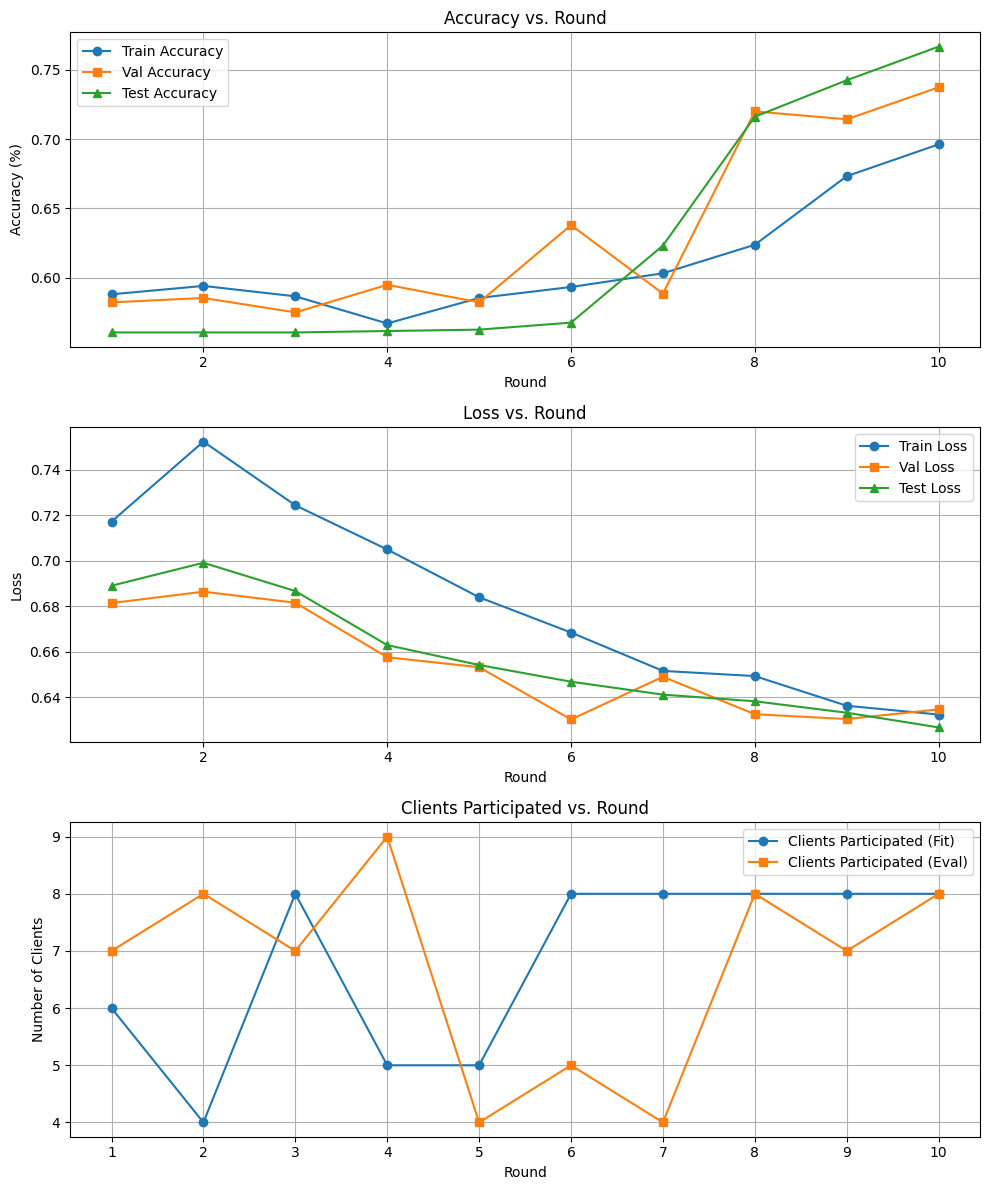

In [31]:
plt.figure(figsize=(10, 12))

# Biểu đồ Accuracy
plt.subplot(3, 1, 1)
plt.plot(range(1, len(HISTORY["train_accuracy"]) + 1), HISTORY["train_accuracy"], label="Train Accuracy", marker='o')
plt.plot(range(1, len(HISTORY["val_accuracy"]) + 1), HISTORY["val_accuracy"], label="Val Accuracy", marker='s')
plt.plot(range(1, len(HISTORY["test_accuracy"]) + 1), HISTORY["test_accuracy"], label="Test Accuracy", marker='^')
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Round")
plt.legend()
plt.grid(True)

# Biểu đồ Loss
plt.subplot(3, 1, 2)
plt.plot(range(1, len(HISTORY["train_loss"]) + 1), HISTORY["train_loss"], label="Train Loss", marker='o')
plt.plot(range(1, len(HISTORY["val_loss"]) + 1), HISTORY["val_loss"], label="Val Loss", marker='s')
plt.plot(range(1, len(HISTORY["test_loss"]) + 1), HISTORY["test_loss"], label="Test Loss", marker='^')
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Loss vs. Round")
plt.legend()
plt.grid(True)

# Biểu đồ Clients Participated
plt.subplot(3, 1, 3)
plt.plot(range(1, len(HISTORY["clients_participated_fit"]) + 1), HISTORY["clients_participated_fit"], label="Clients Participated (Fit)", marker='o')
plt.plot(range(1, len(HISTORY["clients_participated_eval"]) + 1), HISTORY["clients_participated_eval"], label="Clients Participated (Eval)", marker='s')
plt.xlabel("Round")
plt.ylabel("Number of Clients")
plt.title("Clients Participated vs. Round")
plt.legend()
plt.grid(True)
plt.xticks(range(1, max(len(HISTORY["clients_participated_fit"]), len(HISTORY["clients_participated_eval"])) + 1))

plt.tight_layout()